# Mixture of Gaussians for Apple vs Non-Apple pixels.

In [8]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Part A

Load both colour images and ground truths from apples folder.

In [9]:
# Define paths to the files
colourFiles = glob.glob("apples/*.jpg")
groundTruthFiles = glob.glob("apples/*.png")

Small helper functions that are used.

In [11]:
# function to scale pixel values to be between 0 and 1 from the 0-255 range
def scale_to_zero_one(img):
    return img / 255.0

In [12]:
# function to count number of black and white pixels (useful to check for testing mask images)
def count_black_and_white_pxs(img):
    countBlack = 0
    countWhite = 0
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row, col] == 0:
                countBlack += 1
            else:
                countWhite += 1

    return countBlack, countWhite

In [13]:
# load the colour images
ColorImgs = []
for myFile in colourFiles:
    im = plt.imread(myFile)
    im = im[:, :, 0: 3] # only take the RGB channels
    im = scale_to_zero_one(im)
    ColorImgs.append(im)

In [14]:
# load the ground truth masks
GroundTruthMasks = []
for myFile in groundTruthFiles:
    im = cv2.imread(myFile, 0)
    im = scale_to_zero_one(im)
    GroundTruthMasks.append(im)

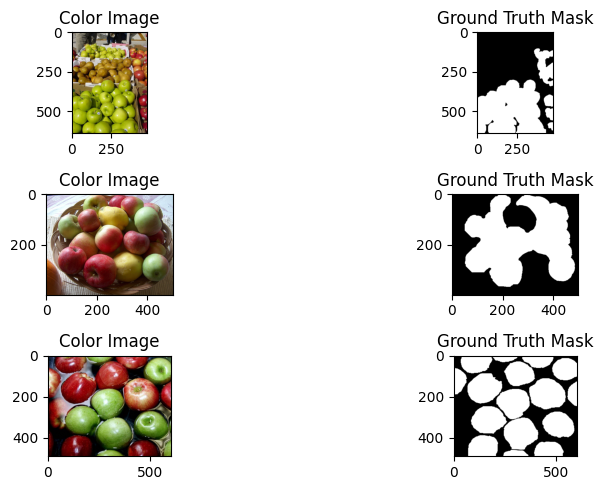

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 5))
for i in range(3):
    # Colour image on left
    axes[i, 0].imshow(ColorImgs[i])
    axes[i, 0].set_title('Color Image')

    # Ground truth on right
    axes[i, 1].imshow(GroundTruthMasks[i], cmap=plt.cm.gray)
    axes[i, 1].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

## Part B

NOTE IMPORTANT: these are helper functions I am reusing from the previous practicalMixGauss exercises (in particular fitMixGauss() and getMixGaussLogLike() from practicalMixGaussC) with some modifications when necessary i.e., removing plotting from fitMixGauss as it's not necessary in our case.

In [16]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0

        # iterate over each individual Gaussian component
        for cGauss in range(mixGaussEst['k']):
            weight = mixGaussEst['weight'][cGauss]
            mean = mixGaussEst['mean'][:, cGauss]
            covariance = mixGaussEst['cov'][:, :, cGauss]

            # compute multivariate gaussian likelihood given thisData, mean and covariance
            # we simply use the formula for the multivariate gaussian
            gaussian_likelihood = (1 / ((2 * np.pi) ** (nDims/2) * (np.linalg.det(covariance) ** 0.5))) * np.exp(-0.5 * np.matmul(np.matmul((thisData - mean).T, np.linalg.inv(covariance)), (thisData - mean)))

            like += weight * gaussian_likelihood
        
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item()  

Note there are certain inner parameters within fitMixGauss() that could be changed like the nIter and epsilon. Here, nIter refers to the maximum number of iterations the EM algorithm will run for and epsilon is the threshold for which the algorithm will stop early in case the log likelihood change between iterations falls below or is equal to it. A better approach would have been to continue until convergence is reached, using the epsilon parameter as the only metric to determine when to stop. However, for computational reasons, nIter is 30, and epsilon is 3.

In [17]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30 # max number of iterations
    epsilon = 3 # epsilon threshold which is to be used as another stopping metric

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # iterate over each individual gaussian
            for cGauss in range(mixGaussEst['k']):
                weight = mixGaussEst['weight'][cGauss]
                mean = mixGaussEst['mean'][:, cGauss]
                covariance = mixGaussEst['cov'][:, :, cGauss]

                # compute multivariate gaussian likelihood given data[:, cData], mean and covariance
                gaussian_likelihood = (1 / ((2 * np.pi) ** (nDims/2) * (np.linalg.det(covariance) ** 0.5))) * np.exp(-0.5 * np.matmul(np.matmul((data[:, cData] - mean).T, np.linalg.inv(covariance)), (data[:, cData] - mean)))
                postHidden[cGauss, cData] = weight * gaussian_likelihood
            
            postHidden[:, cData] = postHidden[:, cData] / np.sum(postHidden[:, cData]) 
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            # Note equations are from MoGCribSheet
            # sum of i = 1 to I of rik (cGauss fixed) divided by sum over all responsibilities
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :]) / np.sum(postHidden)
            
            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            # sum of i = 1 to I of rik multiplied each time by xi (data point from data) divided by sum of i = 1 to I of rik (cGauss fixed)
            mixGaussEst['mean'][:,cGauss] = np.matmul(data, postHidden[cGauss, :]) / np.sum(postHidden[cGauss, :])
            
            
            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            # Calculate mean differences for each data point
            meanDiff = data - mixGaussEst['mean'][:, cGauss][:, np.newaxis]

            # Calculate the weighted mean differences
            # rik * (xi - muk^[t+1]])
            weightedMeanDiff = postHidden[cGauss, :] * meanDiff

            # Calculate the covariance matrix update
            # rik * (xi - muk^[t+1]])(xi - muk^[t+1]]).T / sum of responsibilities
            mixGaussEst['cov'][:, :, cGauss] = np.matmul(weightedMeanDiff, meanDiff.T) / np.sum(postHidden[cGauss, :])
            

        # calculate the log likelihood
        newLogLike = getMixGaussLogLike(data, mixGaussEst)
        if abs(newLogLike-logLike) <= epsilon:
            logLike = newLogLike
            print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
            break
        logLike = newLogLike
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

Load training data for both Apple and NonApple.

In [18]:
# get all apple pixels and non-apple pixels
RGBApple = []
RGBNonApple = []

for img, mask in zip(ColorImgs, GroundTruthMasks):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            maskData = mask[i, j]

            if maskData == 0:
                # non-apple data
                RGBNonApple.append(img[i, j, :])
            else:
                RGBApple.append(img[i, j, :])

In [19]:
# convert list into np.array and then ensure rows are RGB and individual pixels are the columns
matrix_RGBApple = np.array(RGBApple).T.reshape(3, -1)
matrix_RGBNonApple = np.array(RGBNonApple).T.reshape(3, -1)

Check the shape of the matrices to test whether we have the correct number of apple and non-apple pixels as required by the ground truth masks.

In [22]:
matrix_RGBApple.shape

(3, 429589)

In [23]:
matrix_RGBNonApple.shape

(3, 370711)

In [24]:
# check if we have the correct number of apple pixels vs non-apple pixels
mask0Black, mask0White = count_black_and_white_pxs(GroundTruthMasks[0])
mask1Black, mask1White = count_black_and_white_pxs(GroundTruthMasks[1])
mask2Black, mask2White = count_black_and_white_pxs(GroundTruthMasks[2])

In [25]:
# does non-apple pixels match the total number of black pixels?
mask0Black + mask1Black + mask2Black == matrix_RGBNonApple.shape[1]

True

In [26]:
# does apple pixels match the total number of white pixels?
mask0White + mask1White + mask2White == matrix_RGBApple.shape[1]

True

Apply mixture of Gaussians to both apple pixels and non-apple pixels. Parameter k for the mixture of gaussian is chosen to be 3. Note choice of parameter k could be done more rigorously for example using cross-validation, but here we decided to use 3.

In [29]:
mixGaussApple = fitMixGauss(matrix_RGBApple, 3)

Log Likelihood Iter 0 : -2264166.915

Log Likelihood After Iter 0 : 286816.384

Log Likelihood After Iter 1 : 294322.679

Log Likelihood After Iter 2 : 318491.618

Log Likelihood After Iter 3 : 355740.842

Log Likelihood After Iter 4 : 389743.395

Log Likelihood After Iter 5 : 413659.021

Log Likelihood After Iter 6 : 431199.485

Log Likelihood After Iter 7 : 455102.684

Log Likelihood After Iter 8 : 480854.047

Log Likelihood After Iter 9 : 503888.465

Log Likelihood After Iter 10 : 526261.048

Log Likelihood After Iter 11 : 547051.665

Log Likelihood After Iter 12 : 563199.790

Log Likelihood After Iter 13 : 570481.341

Log Likelihood After Iter 14 : 572855.874

Log Likelihood After Iter 15 : 573986.250

Log Likelihood After Iter 16 : 574869.304

Log Likelihood After Iter 17 : 575721.327

Log Likelihood After Iter 18 : 576632.367

Log Likelihood After Iter 19 : 577681.828

Log Likelihood After Iter 20 : 578972.695

Log Likelihood After Iter 21 : 580661.777

Log Likelihood After Iter 

In [30]:
mixGaussApple

{'d': 3,
 'k': 3,
 'weight': array([0.38961356, 0.20987811, 0.40050834]),
 'mean': array([[0.70247941, 0.4227212 , 0.49737434],
        [0.57603836, 0.06007475, 0.54121124],
        [0.41790813, 0.05339024, 0.08560178]]),
 'cov': array([[[0.01812608, 0.02250645, 0.03679225],
         [0.0117529 , 0.00389756, 0.03634823],
         [0.02044108, 0.00456782, 0.00505856]],
 
        [[0.0117529 , 0.00389756, 0.03634823],
         [0.06444004, 0.00331003, 0.04232386],
         [0.04405906, 0.00229404, 0.00447835]],
 
        [[0.02044108, 0.00456782, 0.00505856],
         [0.04405906, 0.00229404, 0.00447835],
         [0.04867103, 0.00258051, 0.00734788]]])}

In [27]:
mixGaussNonApple = fitMixGauss(matrix_RGBNonApple, 3)

Log Likelihood Iter 0 : -2288630.307

Log Likelihood After Iter 0 : 437675.577

Log Likelihood After Iter 1 : 510602.877

Log Likelihood After Iter 2 : 585852.275

Log Likelihood After Iter 3 : 615300.461

Log Likelihood After Iter 4 : 629281.126

Log Likelihood After Iter 5 : 640910.539

Log Likelihood After Iter 6 : 648461.988

Log Likelihood After Iter 7 : 652106.973

Log Likelihood After Iter 8 : 654431.730

Log Likelihood After Iter 9 : 656710.002

Log Likelihood After Iter 10 : 659176.733

Log Likelihood After Iter 11 : 661660.881

Log Likelihood After Iter 12 : 663973.481

Log Likelihood After Iter 13 : 666234.341

Log Likelihood After Iter 14 : 668690.379

Log Likelihood After Iter 15 : 671484.648

Log Likelihood After Iter 16 : 674459.104

Log Likelihood After Iter 17 : 677397.094

Log Likelihood After Iter 18 : 680581.308

Log Likelihood After Iter 19 : 684927.669

Log Likelihood After Iter 20 : 691349.983

Log Likelihood After Iter 21 : 700242.587

Log Likelihood After Iter 

In [28]:
mixGaussNonApple

{'d': 3,
 'k': 3,
 'weight': array([0.40841248, 0.118527  , 0.47306052]),
 'mean': array([[0.60325836, 0.02692298, 0.43105904],
        [0.56754562, 0.02337308, 0.31727779],
        [0.52763301, 0.02451079, 0.10278337]]),
 'cov': array([[[0.06052195, 0.00104466, 0.0481445 ],
         [0.06268774, 0.00078385, 0.04091756],
         [0.06452123, 0.00058813, 0.01207126]],
 
        [[0.06268774, 0.00078385, 0.04091756],
         [0.06952763, 0.00086308, 0.04948498],
         [0.07321853, 0.00074357, 0.01351842]],
 
        [[0.06452123, 0.00058813, 0.01207126],
         [0.07321853, 0.00074357, 0.01351842],
         [0.08511804, 0.00093699, 0.01004446]]])}

## Part C

Note to compute posterior of being 'apple', we need to define the priors. From our training images it seems like there is a balance between number of apple and non-apple pixels so we set the priorApple probability to be 0.5 (and thus priorNonApple to be 0.5 as well).

In [31]:
# define priors for apple and non-apple
priorApple = 0.5
priorNonApple = 0.5

We define functions to compute the likelihoods, and then the posterior based on these likelihoods using Bayes rule.

In [32]:
def get_likelihood(mixGaussEst, image):
    # get data in form d by n from image
    data = image.reshape(image.shape[0]*image.shape[1], image.shape[2]).T
    nDims, nData = data.shape
    num_mixture_components = mixGaussEst['k']
    likelihoods = np.zeros(nData)
    
    # iterate over each data point
    for cData in range(nData):
        likelihood = 0
        # iterate over individual gaussian component
        for cGauss in range(num_mixture_components):
            weight = mixGaussEst['weight'][cGauss]
            mean = mixGaussEst['mean'][:, cGauss]
            covariance = mixGaussEst['cov'][:, :, cGauss]
            
            gauss_prob = (1 / ((2 * np.pi) ** (nDims/2) * (np.linalg.det(covariance) ** 0.5))) * np.exp(-0.5 * np.matmul(np.matmul((data[:, cData] - mean).T, np.linalg.inv(covariance)), (data[:, cData] - mean)))
            
            likelihood += (weight * gauss_prob)
        
        likelihoods[cData] = likelihood
        
    # reshape likelihoods to be in shape of (height, width) image
    likelihoods = likelihoods.reshape(image.shape[0], image.shape[1])
    
    return likelihoods
    
def get_posterior(image, priorApple, priorNonApple):
    # similar to mixPracticalGaussA
    # calculate likelihood given mixture of gaussian apple model
    likeApple = get_likelihood(mixGaussApple, image)
    # calculate likelihood given mixture of gaussian non-apple model
    likeNonApple = get_likelihood(mixGaussNonApple, image)
    # compute posterior apple using bayes rule
    # bayes rule tells us that
    # posterior = likelihood * prior / evidence <=>
    # posteriorApple = (likeApple * priorApple) / (likeApple * priorApple + likeNonApple * priorNonApple) 
    posteriorApple = likeApple * priorApple / (likeApple * priorApple + likeNonApple * priorNonApple)
    
    return posteriorApple

Load test images from testApples individually (note these do not include myTests which are loaded later for part E). Then, we get the posterior and comment on it.

In [45]:
# load the first test image
test1 = plt.imread("testApples\Apples_by_MSR_MikeRyan_flickr.jpg")
test1 = test1[:, :, 0: 3] # only take the RGB channels
test1 = scale_to_zero_one(test1)

In [46]:
# compute the posterior for the first test image
test1Posterior = get_posterior(test1, priorApple, priorNonApple)

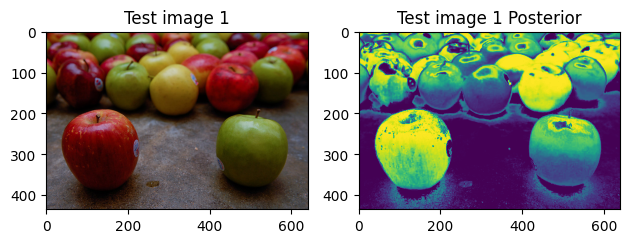

In [47]:
# we display the first test image with its posterior, and comment on it.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(test1)
ax1.set_title("Test image 1")

ax2.imshow(test1Posterior)
ax2.set_title("Test image 1 Posterior")

plt.tight_layout()
plt.show()

Qualitatively, it seems to recognise that the floor is not an apple (as the posterior shows a low probability), wherease apples display a higher probability with peaks at red apples. Yellow apples and green apples have a lower probability compared to red apples (but still greater than the floor), which suggests that the model didn't fully learn to characterise those particular apples. Perhaps, training the mixture of gaussians model for more iterations would have helped in this case.

In [49]:
# load the second test image
test2 = plt.imread("testApples\\audioworm-QKUJj2wmxuI-original.jpg")
test2 = test2[:, :, 0: 3] # only take the RGB channels
test2 = scale_to_zero_one(test2)

In [50]:
# compute the posterior for the second test image
test2Posterior = get_posterior(test2, priorApple, priorNonApple)

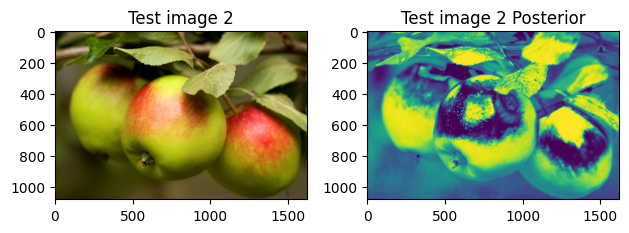

In [51]:
# we display the second test image with its posterior, and comment on it.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(test2)
ax1.set_title("Test image 2")

ax2.imshow(test2Posterior)
ax2.set_title("Test image 2 Posterior")

plt.tight_layout()
plt.show()

Qualitatively, it appears that the background is being recognised to be closer to apple pixels rather than being closer to non-apple pixels, possibly because of the similarity to the green apple colour. The results are not totally great, as it appears that it has lower probability around the red sections of the green apples, which instead should still be recognised as apple pixels (i.e., should have higher posterior probability than the green background). Perhaps, expanding the dataset and further training of the models could help better capture these apples.

In [52]:
# load the third test image
test3 = plt.imread("testApples\Bbr98ad4z0A-ctgXo3gdwu8-original.jpg")
test3 = test3[:, :, 0: 3] # only take the RGB channels
test3 = scale_to_zero_one(test3)

In [53]:
# compute the posterior for the third test image
test3Posterior = get_posterior(test3, priorApple, priorNonApple)

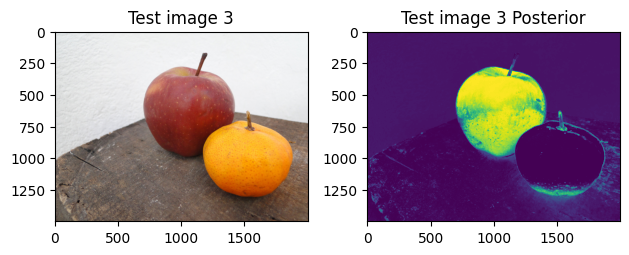

In [55]:
# we display the third test image with its posterior, and comment on it.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(test3)
ax1.set_title("Test image 3")

ax2.imshow(test3Posterior)
ax2.set_title("Test image 3 Posterior")

plt.tight_layout()
plt.show()

Qualitatively, it appears to recognise the only apple next to the orange very well, as it has highest posterior probability compared to the rest. The orange, and the background have a very low posterior probability indicating that it recognises these as non-apple pixels. Thus, in this particular case, the model is effectively determining which pixels are apple and non-apple.

## Part D

We define a range of thresholds. For each threshold, we compute the true positive rate (tpr) and false positive rate (fpr). We then plot the ROC curve, with tpr in y-axis and fpr in x-axis.  

In [75]:
# we define a range of thresholds
thresholds = np.linspace(0, 1, num=100)

In [76]:
# function for computing tpr (true positive rate) and fpr (false positive rate)
def compute_tpr_and_fpr(posteriorImg, groundTruthImg, threshold):
    predImg = np.where(posteriorImg >= threshold, 1, 0)
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for row in range(groundTruthImg.shape[0]):
        for col in range(groundTruthImg.shape[1]):
            if predImg[row, col] == 1 and groundTruthImg[row, col] == 1:
                true_positive += 1
            elif predImg[row, col] == 0 and groundTruthImg[row, col] == 0:
                true_negative += 1
            elif predImg[row, col] == 1 and groundTruthImg[row, col] == 0:
                false_positive += 1
            elif predImg[row, col] == 0 and groundTruthImg[row, col] == 1:
                false_negative += 1

    tpr = true_positive / (true_positive + false_negative)
    fpr = false_positive / (false_positive + true_negative)

    return tpr, fpr

In [77]:
# define function to get ROC coordinates
def get_ROC_coordinates(posteriorImg, groundTruthImg, thresholds):
    tpr_coordinates = []
    fpr_coordinates = []

    for threshold in thresholds:
        tpr, fpr = compute_tpr_and_fpr(posteriorImg, groundTruthImg, threshold)
        tpr_coordinates.append(tpr)
        fpr_coordinates.append(fpr)

    return tpr_coordinates, fpr_coordinates

For the third test image from part C, we want to quantify the result by reporting the ROC curve.

In [78]:
# ensure we load ground truth
test3GroundTruth = cv2.imread("testApples\Bbr98ad4z0A-ctgXo3gdwu8-original.png", 0)
test3GroundTruth = scale_to_zero_one(test3GroundTruth)

In [79]:
# get the coordinates of the ROC curve for each threshold in our range
tpr_coordinates_test3, fpr_coordinates_test3 = get_ROC_coordinates(test3Posterior, test3GroundTruth, thresholds)

We plot the ROC curve for Test image 3 (the one with a ground truth mask).

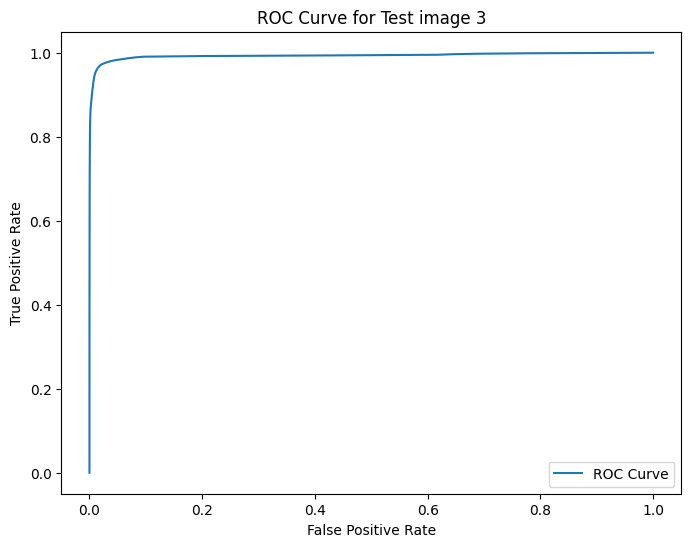

In [82]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_coordinates_test3, tpr_coordinates_test3, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test image 3')
plt.legend()
plt.show()

The closer the ROC curve is to the top-left corner, the better the performace of the model. In this case, we indeed see that it's very close to reaching (0, 1) indicating that our model is doing a really good job at distinguishing apples vs non-apple pixels for Test image 3 (which was also highlighted by our qualitative analysis).

## Part E

We load the extra test images in here. Note they are stored in myTests folder inside the testApples folder. Additionally, these test images come from http://search.creativecommons.org/ and I used Windows Paint to create their ground truth masks which are also stored in the myTests folder. 

In [56]:
# load My test image 1
mytest1 = plt.imread("testApples\myTests\myapple_test1.jpg")
mytest1 = mytest1[:, :, 0: 3] # only take the RGB channels
mytest1 = scale_to_zero_one(mytest1)

In [57]:
# load My test image 2
mytest2 = plt.imread("testApples\myTests\myapple_test2.jpg")
mytest2 = mytest2[:, :, 0: 3] # only take the RGB channels
mytest2 = scale_to_zero_one(mytest2)

We start with Qualitative analysis by computing the posterior as we did in part C.

In [60]:
# computer posterior for My test image 1
mytest1Posterior = get_posterior(mytest1, priorApple, priorNonApple)

In [61]:
# compute posterior for My test image 2
mytest2Posterior = get_posterior(mytest2, priorApple, priorNonApple)

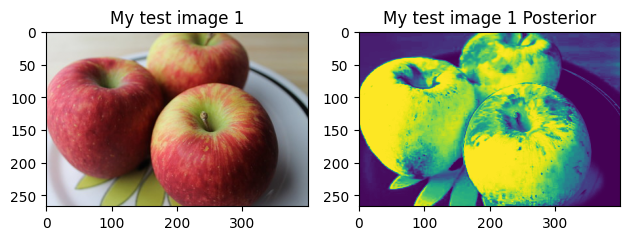

In [63]:
# we display my first test image with its posterior, and comment on it.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(mytest1)
ax1.set_title("My test image 1")

ax2.imshow(mytest1Posterior)
ax2.set_title("My test image 1 Posterior")

plt.tight_layout()
plt.show()

Qualitatively, it appears to recognise the apples since they have a higher posterior probability compared to the background, and the plate. However, it also recognies the green petals/sections in the plate as apples too, which shouldn't be the case as it's part of the plate design. 

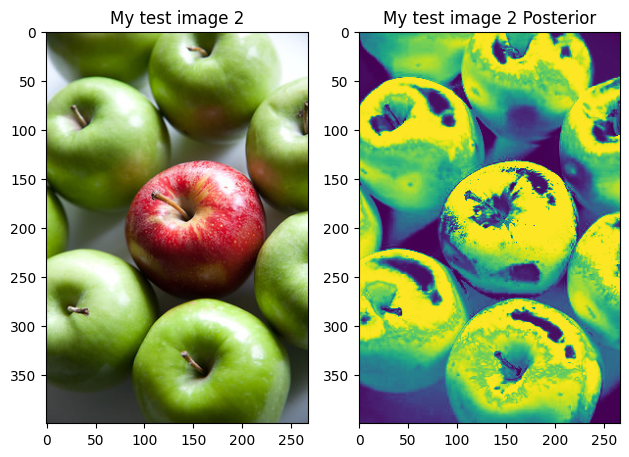

In [64]:
# we display my second test image with its posterior, and comment on it.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(mytest2)
ax1.set_title("My test image 2")

ax2.imshow(mytest2Posterior)
ax2.set_title("My test image 2 Posterior")

plt.tight_layout()
plt.show()

Qualitatively, it appears to recognise all the apples due to having higher posterior probabilities compared to the white floor. However, the reflection of the light in those apples, which appear as white sections in those apples have low posterior probability suggesting that the model is not able to discern the white/bright areas in the apple as being part of the apple. 

We then do Quantitative analysis. We also load the ground truths for my test images.

In [83]:
# ensure we load ground truth for mytest1
mytest1GroundTruth = cv2.imread("testApples\myTests\myapple_test1_ground_truth.jpg", 0)
mytest1GroundTruth = scale_to_zero_one(mytest1GroundTruth)

In [84]:
# ensure we load ground truth for mytest2
mytest2GroundTruth = cv2.imread("testApples\myTests\myapple_test2_ground_truth.jpg", 0)
mytest2GroundTruth = scale_to_zero_one(mytest2GroundTruth)

In [85]:
# get the coordinates of the ROC curve for each threshold in our range
tpr_coordinates_mytest1, fpr_coordinates_mytest1 = get_ROC_coordinates(mytest1Posterior, mytest1GroundTruth, thresholds)

In [86]:
# get the coordinates of the ROC curve for each threshold in our range
tpr_coordinates_mytest2, fpr_coordinates_mytest2 = get_ROC_coordinates(mytest2Posterior, mytest2GroundTruth, thresholds)

We plot the ROC curve for My test image 1.

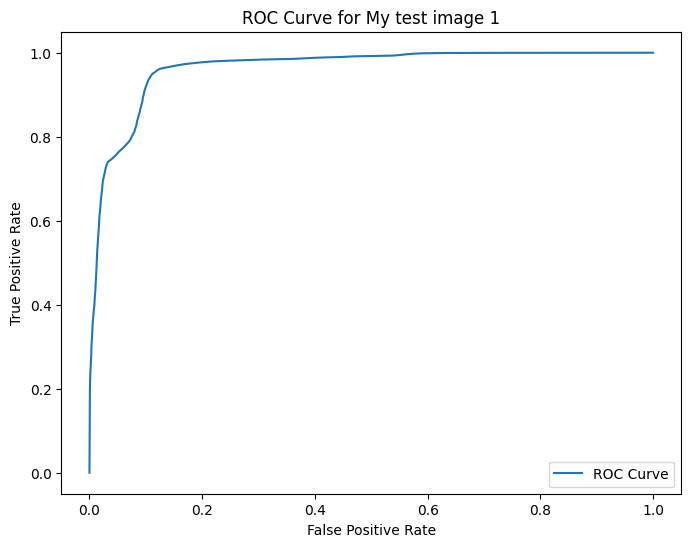

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_coordinates_mytest1, tpr_coordinates_mytest1, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for My test image 1')
plt.legend()
plt.show()

The image above shows the ROC curve being slightly pushed to right, but still remains close to the top-left corner indicating that the model shows some capability in distinguishing between apple and non-apple pixels, but there are still false positives, which was highlighted in our quantitative analysis where we saw the petals design of the plate still being recognised as an apple when it shouldn't have been.

We plot the ROC curve for My test image 2.

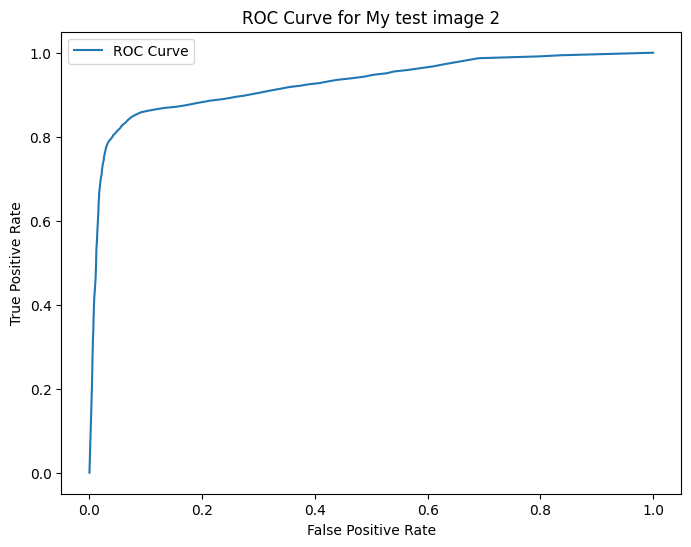

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_coordinates_mytest2, tpr_coordinates_mytest2, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for My test image 2')
plt.legend()
plt.show()

The image above shows the ROC curve being slightly below the top left corner which indicates that while the model performance is reasonably good, there are still misclassifications due to a lower true postive peak at the left side of the ROC curve, which was also highlighted in our qualitative analysis where the reflections of light in the apples were not being recognised as apple (even though they are apple pixels).

## Part F

We should be using the training set to train the initial models for apple pixels and non-apple pixels using mixture of gaussians. Afterwards, we should use the validation set to fine tune the hyperparameters of the mixture of gaussians model, in other words, the parameter k for the number of individual gaussian components for each mixture model (which in our case we didn't, as I picked k to be 3). Finally, after refining the models, we can then test the models to compute whether we can generalise to new, unseen data and still have minimal error in correctly identifying apple vs non-apple pixels.